## Preparation

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large

%matplotlib inline

print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• GPU Device Found.


In [ ]:
DATASET_DIR = '/content/drive/MyDrive/capstone_machine_learning/capstone_dataset/arranged_dataset' # Change based on dataset dir on your system/device
MODEL_DIR = "/content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models" # Change based on dataset dir on your system/device
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'validation')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
BATCH_SIZE = 128

## Load images using ImageDataGenerator

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


## Debug dataset generators

In [ ]:
# list(dir(train_generator)) # to know what attributes and methods the generator has

In [ ]:
print('Number of classes:', train_generator.num_classes)
print('Class map:', train_generator.class_indices)
print('Auto-shuffle:', train_generator.shuffle, end='\n\n')

print('Number of classes:', val_generator.num_classes)
print('Class map:', val_generator.class_indices)
print('Auto-shuffle:', val_generator.shuffle, end='\n\n')

print('Number of classes:', test_generator.num_classes)
print('Class map:', test_generator.class_indices)
print('Auto-shuffle:', test_generator.shuffle, end='\n\n')

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True



Train samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


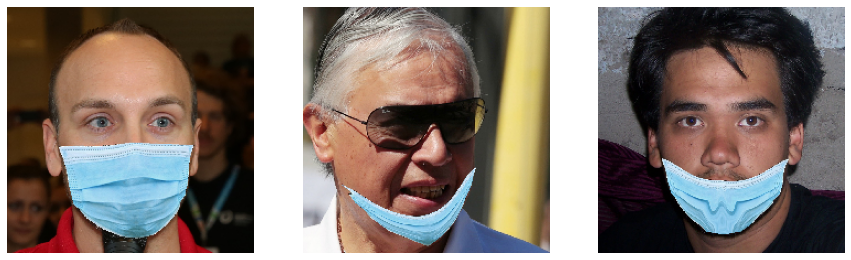

Validation samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


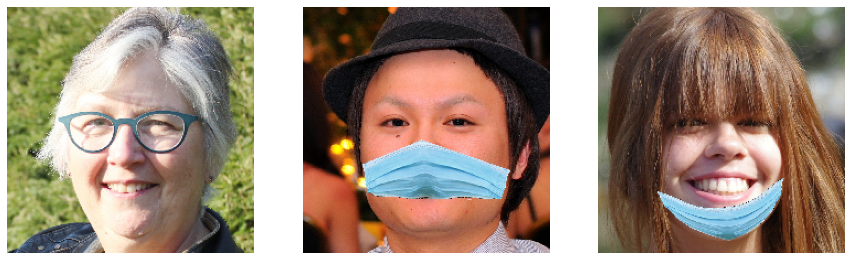

Test samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


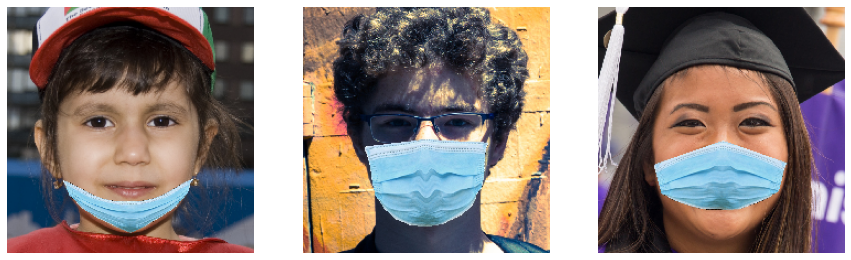

In [ ]:
# Sample some images in data generator to display

def display_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples')
display_samples(train_generator)
print('Validation samples')
display_samples(val_generator)
print('Test samples')
display_samples(test_generator)

## Build Model with Hand-Made CNN Scenario 1

In this scenario, we'd be create a model with a series of `2D Convolutions` and `2D Max Poolings`, a `Flatten` layer, and followed by a bunch of `Dense` FC layers to see improvement over using `MobileNetV3Large`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric. Because it contains relatively more shallow networks, we increase the training epochs to 20.

In [ ]:
model = tf.keras.models.Sequential([
    # Your Code Here
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
print(model.summary())

# Compile Model. 
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_train,
    validation_data=val_generator,
    validation_steps=steps_val,
    shuffle=True,
    epochs=20,
    verbose=1
)

Epoch 1/20
78/78 [==============================] - 4557s 58s/step - loss: 0.9668 - accuracy: 0.5776 - val_loss: 0.0939 - val_accuracy: 0.9734
Epoch 2/20
78/78 [==============================] - 302s 4s/step - loss: 0.1043 - accuracy: 0.9708 - val_loss: 0.0662 - val_accuracy: 0.9807
Epoch 3/20
78/78 [==============================] - 300s 4s/step - loss: 0.0529 - accuracy: 0.9836 - val_loss: 0.0407 - val_accuracy: 0.9901
Epoch 4/20
78/78 [==============================] - 304s 4s/step - loss: 0.0414 - accuracy: 0.9865 - val_loss: 0.0360 - val_accuracy: 0.9901
Epoch 5/20
78/78 [==============================] - 300s 4s/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.0417 - val_accuracy: 0.9891
Epoch 6/20
78/78 [==============================] - 301s 4s/step - loss: 0.0322 - accuracy: 0.9905 - val_loss: 0.0368 - val_accuracy: 0.9917
Epoch 7/20
78/78 [==============================] - 304s 4s/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.0294 - val_accuracy: 0.9937
Epoch 8/20


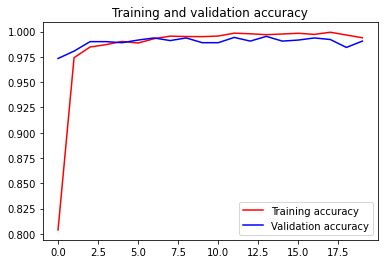

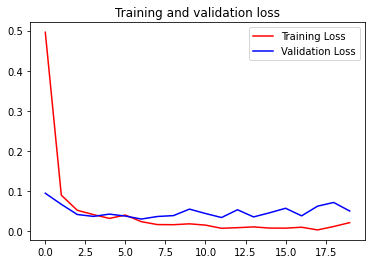

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions = list(model.predict(test_generator))
ground_truth = test_generator.classes
print(predictions)
print(ground_truth)

[array([1.8931821e-09, 1.7009404e-11, 7.7959747e-08, 3.0738698e-09,
       9.9999988e-01], dtype=float32), array([1.7691398e-05, 1.0698919e-02, 5.6789001e-04, 9.8820961e-01,
       5.0588773e-04], dtype=float32), array([4.2648791e-09, 4.6964724e-12, 7.5733169e-08, 1.4254716e-09,
       9.9999988e-01], dtype=float32), array([3.8283713e-05, 2.1295430e-06, 9.9992895e-01, 8.4012655e-09,
       3.0579340e-05], dtype=float32), array([7.6961093e-10, 2.2004325e-12, 1.0000000e+00, 9.0761704e-11,
       3.2149444e-12], dtype=float32), array([1.0070848e-08, 5.9425229e-08, 7.8007433e-06, 9.9999142e-01,
       6.8236221e-07], dtype=float32), array([1.2982086e-17, 1.0000000e+00, 1.0792032e-12, 2.3127737e-15,
       3.3295899e-10], dtype=float32), array([2.4422768e-06, 2.2586141e-04, 1.3109096e-04, 9.9845421e-01,
       1.1864702e-03], dtype=float32), array([7.5779438e-11, 1.2154064e-10, 3.4697649e-08, 5.1543974e-08,
       9.9999988e-01], dtype=float32), array([1.3084582e-09, 9.9488438e-12, 1.000000

In [ ]:
lst = list()
for i in range(len(predictions)):
  lst.append(np.argmax(predictions[i]))
print(lst)

[4, 3, 4, 2, 2, 3, 1, 3, 4, 2, 0, 4, 1, 0, 1, 4, 3, 3, 1, 3, 1, 1, 0, 1, 4, 3, 4, 1, 1, 2, 4, 3, 0, 4, 3, 2, 1, 0, 2, 3, 3, 0, 1, 4, 1, 1, 2, 0, 3, 4, 4, 0, 1, 0, 2, 4, 1, 0, 0, 0, 1, 3, 3, 1, 0, 4, 2, 1, 1, 4, 2, 0, 2, 0, 1, 4, 1, 0, 2, 2, 2, 3, 4, 1, 0, 1, 0, 2, 0, 1, 1, 2, 0, 2, 4, 3, 4, 1, 2, 2, 3, 0, 2, 1, 0, 0, 2, 1, 3, 1, 4, 2, 4, 2, 3, 0, 3, 2, 4, 1, 1, 3, 4, 0, 2, 1, 2, 0, 0, 1, 0, 1, 1, 3, 3, 4, 1, 4, 1, 4, 1, 1, 4, 4, 0, 0, 1, 4, 4, 3, 1, 0, 3, 3, 1, 3, 0, 0, 4, 4, 3, 1, 3, 0, 3, 1, 3, 0, 4, 0, 3, 1, 4, 1, 1, 0, 3, 2, 1, 0, 2, 1, 3, 3, 1, 0, 0, 3, 3, 4, 4, 2, 4, 3, 2, 2, 2, 2, 0, 0, 4, 4, 1, 1, 1, 4, 4, 0, 0, 0, 2, 1, 3, 0, 4, 2, 0, 1, 1, 2, 2, 2, 1, 3, 2, 3, 0, 0, 1, 1, 1, 0, 2, 3, 4, 3, 2, 4, 1, 3, 4, 0, 1, 2, 3, 2, 3, 2, 0, 1, 1, 3, 0, 3, 4, 4, 2, 3, 3, 2, 1, 4, 1, 4, 1, 0, 2, 2, 4, 0, 3, 1, 1, 0, 1, 4, 3, 3, 3, 0, 2, 2, 0, 1, 3, 0, 0, 1, 2, 1, 3, 2, 3, 3, 4, 3, 4, 2, 2, 3, 3, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 4, 3, 4, 2, 3, 1, 3, 0, 3, 3, 4, 4, 0, 4, 0, 3, 3, 2, 4, 3, 0, 3, 

In [ ]:
evaluationa = model.evaluate(train_generator, steps=20)
evaluationb = model.evaluate(val_generator)
evaluationc = model.evaluate(test_generator)
print(evaluationa)
print(evaluationb)
print(evaluationc)

16/16 [==============================] - 51s 3s/step - loss: 0.0540 - accuracy: 0.9910
[0.025212988257408142, 0.994921863079071]
[0.049472879618406296, 0.9904999732971191]
[0.05395430698990822, 0.9909999966621399]


### Save Model

In [ ]:
model.save(os.path.join(MODEL_DIR, 'model_cnn_scenario_1'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_cnn_scenario_1/assets


## Test Model with upload image

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

In [ ]:
demo_datagen = ImageDataGenerator(rescale=1/255)
demo_generator = test_datagen.flow_from_directory(
    '/content/images/',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 3 images belonging to 2 classes.


In [ ]:
classes = model.predict(demo_generator)

print(classes)
for i in classes:
    print(np.argmax(i))

[[9.9950135e-01 5.9536642e-08 3.5659273e-04 1.7353657e-09 1.4206143e-04]
 [1.1254932e-07 9.9992251e-01 1.2825441e-06 4.8046580e-09 7.6080971e-05]
 [8.7883276e-13 9.9999964e-01 1.9447870e-09 7.8169299e-10 3.6514277e-07]]
0
1
1
